this is the best (only) Rigetti data. Re-analysing with groups of 512 qubits (02/02/22)

In [1]:
#18/05/21: stripped down version of IBM code for running locally on IBM Qsystem 1
import math
import certifi
# Importing standard Qiskit libraries and configuring account
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from scipy import stats

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer,BasicAer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.visualization import circuit_drawer

In [2]:
#in 1QX data the last 5 data points are so bad I think its fair to ignore them, they appear as clear outliers. 
#Anyway looks very very poor
from scipy import stats
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
ii=complex(0,1)
#number of total repitions
nrep=50
#number of repitions for the training 
nrand=30
#number of times we make a measurement before recalibrating
nper=5
nrepT=round(nrep/nper)
#rotation angle
th=0
#decoherence
p=0.5
#no of shots 
shots=8192
shotseff=shots/2
grouping=8
shotseff2=shotseff/grouping
#results
mse1q1=[]
mse1qMIT1=[]
mse1qMIT_alt1=[]
alt_mse1qMIT1=[]
alt_mse1qMIT_alt1=[]

predx=[]
predy=[]

predxMIT=[]
predyMIT=[]

#useful to check whether x or y is worse
msex=[]
msey=[]
msex_alt=[]
msey_alt=[]

cnameA='rigetti'
cname=cnameA
n1x=[];
n0x=[];
n1y=[];
n0y=[];

n1xMT=[];
n0xMT=[];
n1yMT=[];
n0yMT=[];

n1xMT_alt=[];
n0xMT_alt=[];
n1yMT_alt=[];
n0yMT_alt=[];

msealt=[]
msealtX=[]
msealtY=[]
msealtOG=[]

intxvec=[]
intyvec=[]
for totcount in range(nrepT):
    thvec=np.linspace(-0.2,0.2,nrand)
    
    #loading real counts
    Fx = np.load(str(cnameA+str("_LR")+str("/")+str('run')+str(totcount)+str("_1Q_est_X")+str('th=')+str(th)+str('p=')+str(p)+str("/")+str("training_data")+str(".npz")))
    ax=Fx['arr_0']
    Fy = np.load(str(cnameA+str("_LR")+str("/")+str('run')+str(totcount)+str("_1Q_est_Y")+str('th=')+str(th)+str('p=')+str(p)+str("/")+str("training_data")+str(".npz")))
    ay=Fy['arr_0']

    noisy1QX=1/((1-p))*(1/4096)*(ax[0]-ax[1])
    noisy1QY=1/((1-p))*(1/4096)*(ay[0]-ay[1])
    

    
    #generating data to fit to
    clean1QX=[]
    True1QX=[]
    clean1QY=[]
    True1QY=[]
    thvec=np.linspace(-0.2,0.2,nrand)
    for jj in range(nrand):
        thx=thvec[jj]
        True1QX.append(thx)
        True1QY.append(thx)
    
    #regression
    res1QX_alt = stats.linregress(np.array(noisy1QX),np.array(True1QX))
    
    res1QY_alt = stats.linregress(np.array(noisy1QY),np.array(True1QY))
    
    
#     plt.figure(totcount)
#     plt.plot(True1QX,noisy1QX,'.')
#     plt.figure(totcount+10)
#     plt.plot(True1QY,noisy1QY,'.')
#     plt.plot(True1QY,True1QY)
#     stop
    #measurement results
    Fxres = np.load(str(cnameA+str("_LR")+str("/")+str('run')+str(totcount)+str("_1Q_est")+str('th=')+str(th)+str('p=')+str(p)+str("/")+str("nxvec")+str(".npz")))
    axres=Fxres['arr_0']
    Fyres = np.load(str(cnameA+str("_LR")+str("/")+str('run')+str(totcount)+str("_1Q_est")+str('th=')+str(th)+str('p=')+str(p)+str("/")+str("nyvec")+str(".npz")))
    ayres=Fyres['arr_0']
    
    estX=1/((1-p))*(1/4096)*(np.transpose(axres)[0]-np.transpose(axres)[1])
    estY=1/((1-p))*(1/4096)*(np.transpose(ayres)[0]-np.transpose(ayres)[1])



    estxMIT_Aalt=res1QX_alt.intercept + estX

    estyMIT_Aalt=res1QY_alt.intercept + estY
    
    #each of these contains 5 numbers
    n1xtemp=np.transpose(axres)[1]
    n0xtemp=np.transpose(axres)[0]
    n1ytemp=np.transpose(ayres)[1]
    n0ytemp=np.transpose(ayres)[0]
    
    n1x.append(np.transpose(axres)[1])
    n0x.append(np.transpose(axres)[0])
    n1y.append(np.transpose(ayres)[1])
    n0y.append(np.transpose(ayres)[0])


    n1xMT_alt.append(((1-p)*4096*estxMIT_Aalt+4096)/2)
    n0xMT_alt.append(4096-((1-p)*4096*estxMIT_Aalt+4096)/2)

    n1yMT_alt.append(((1-p)*4096*estyMIT_Aalt+4096)/2)
    n0yMT_alt.append(4096-((1-p)*4096*estyMIT_Aalt+4096)/2)

    #saving MSE
    mse1q1.append((estX-th)**2+(estY-th)**2)
    
    
    alt_mse1qMIT_alt1.append((estxMIT_Aalt-th)**2+(estyMIT_Aalt-th)**2)
    

    msex_alt.append((estxMIT_Aalt-th)**2)
    msey_alt.append((estyMIT_Aalt-th)**2)
    
    #saving the estimates
    predx.append(estX)
    predy.append(estY)
    predxMIT.append(estxMIT_Aalt)
    predyMIT.append(estyMIT_Aalt)
    for lll in range(5):
        for outside in range(1000):

                xdata= np.ones(int(shotseff))
                xdata[:n0xtemp[lll]] = 0
                np.random.shuffle(xdata)

                ydata= np.ones(int(shotseff))
                ydata[:n0ytemp[lll]] = 0
                np.random.shuffle(ydata)

                for groupcount in range(grouping):
                    xdataint=xdata[int(groupcount*shotseff2):int((groupcount+1)*shotseff2)]
                    ydataint=ydata[int(groupcount*shotseff2):int((groupcount+1)*shotseff2)]
                    x1=np.count_nonzero(xdataint==1)
                    x0=np.count_nonzero(xdataint==0)
                    y1=np.count_nonzero(ydataint==1)
                    y0=np.count_nonzero(ydataint==0)

                    thx=(x0-x1)/(shotseff2*(1-p))
                    thy=(y0-y1)/(shotseff2*(1-p))

                    thx2=res1QX_alt.intercept+thx
                    thy2=res1QY_alt.intercept+thy
                    
                    msealt.append((thx2-th)**2+(thy2-th)**2)

                    msealtOG.append((thx-th)**2+(thy-th)**2)

                    msealtX.append((thx2-th)**2)
                    msealtY.append((thy2-th)**2)

#                     estXaltMIT.append(thx2)
#                     estYaltMIT.append(thy2)

#                     estXalt.append(thx)
#                     estYalt.append(thy)
    
    
    
    

expvar=2/(((1-p)**2)*shotseff);
expvar2Q=2*(2-p+0.5*p**2)/(((1-p)**2)*shotseff*2);

print("MSE=",np.mean(mse1q1))
# print("mitigated MSE=",np.mean(mse1qMIT1))
# print("alt mitigated MSE=",np.mean(mse1qMIT_alt1))
print("SQL=",expvar)
print("quant adv=",expvar2Q)

print("mitigated MSE without slope=",np.mean(alt_mse1qMIT1))
print("mitigated MSE without slope=",np.mean(alt_mse1qMIT_alt1))

print()
print("512 qubits : ")
expvar2=2/(((1-p)**2)*shotseff2);
expvar2Q2=2*(2-p+0.5*p**2)/(((1-p)**2)*shotseff2*2);
print("SQL=",expvar2)
print("quant adv=",expvar2Q2)
print('mse = ', np.mean(msealt))
print('mse og = ', np.mean(msealtOG))
print('mse x = ', np.mean(msealtX))
print('mse y = ', np.mean(msealtY))
# print("error in x= ", np.mean(msex),"or",np.mean(msex_alt))

# print("error in y= ", np.mean(msey),"or",np.mean(msey_alt))
# print("Predicited theta x and theta y without EM",np.mean(predx),"and",np.mean(predy))
# print("Predicited theta x and theta y with EM",np.mean(predxMIT),"and",np.mean(predyMIT))
    

        

MSE= 0.035952796936035154
SQL= 0.001953125
quant adv= 0.0015869140625
mitigated MSE without slope= nan
mitigated MSE without slope= 0.006223428766526043

512 qubits : 
SQL= 0.015625
quant adv= 0.0126953125
mse =  0.019809678766526045
mse og =  0.049539046936035155
mse x =  0.010049243134199174
mse y =  0.009760435632326864


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


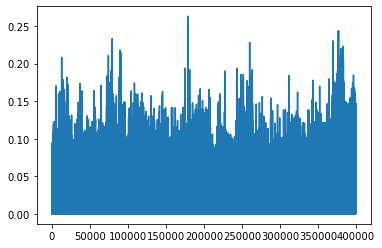

In [3]:
#no outliers to remove in this case
plt.plot(msealt)

12.276708302291853
Single copy MSE = 0.018336807073525627


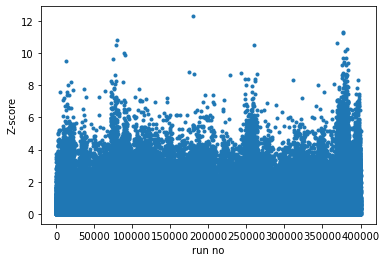

In [5]:
#removing outliers
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(msealt))
print(np.max(z))

plt.plot(z,'.')
plt.ylabel('Z-score')
plt.xlabel('run no')
outlier=np.where(z>3)

mse_upd = np.array(msealt)[(z < 3)]
print('Single copy MSE =',np.mean(mse_upd))


In [4]:

print("Bootstrapping")

#different probability distributions



n1xMT_alt=np.sum(n1xMT_alt)
n0xMT_alt=np.sum(n0xMT_alt)
NT=n1xMT_alt+n0xMT_alt
p0xM_alt=n0xMT_alt/NT
p1xM_alt=n1xMT_alt/NT

n1yMT_alt=np.sum(n1yMT_alt)
n0yMT_alt=np.sum(n0yMT_alt)
NT=n1yMT_alt+n0yMT_alt
p0yM_alt=n0yMT_alt/NT
p1yM_alt=n1yMT_alt/NT

n1x=np.sum(n1x)
n0x=np.sum(n0x)
NT=n1x+n0x
p0x=n0x/NT
p1x=n1x/NT

n1y=np.sum(n1y)
n0y=np.sum(n0y)
NT=n1y+n0y
p0y=n0y/NT
p1y=n1y/NT


mseT=[]
mseTMA=[]
mseT2=[]
mseTMA2=[]
mseTMAx2=[]
mseTMAy2=[]
for hh in range(1000):
    mseint=[]
    mseintMA=[]
    mseint2=[]
    mseintMA2=[]
    mseintMAx2=[]
    mseintMAy2=[]
    for kk in range(50):
       
        rv= np.random.multinomial(4096, [p0x,p1x], size=1)
        rvMA= np.random.multinomial(4096, [p0xM_alt,p1xM_alt], size=1)
        
        n0=rv[0][0]
        n1=rv[0][1]
        est=-1/((1-p))*(1/4096)*(n1-n0)
        
        n0MA=rvMA[0][0]
        n1MA=rvMA[0][1]
        estMA=-1/((1-p))*(1/4096)*(n1MA-n0MA)
        
        rvy= np.random.multinomial(4096, [p0y,p1y], size=1)
        rvMyA= np.random.multinomial(4096, [p0yM_alt,p1yM_alt], size=1)
        
        n0=rvy[0][0]
        n1=rvy[0][1]
        esty=-1/((1-p))*(1/4096)*(n1-n0)
        
        n0MA=rvMyA[0][0]
        n1MA=rvMyA[0][1]
        estMyA=-1/((1-p))*(1/4096)*(n1MA-n0MA)
        
        mseint.append((est-th)**2+(esty-th)**2)
        mseintMA.append((estMA-th)**2+(estMyA-th)**2)
        
    for kk in range(50*grouping):
       
        rv= np.random.multinomial(shotseff2, [p0x,p1x], size=1)
        rvMA= np.random.multinomial(shotseff2, [p0xM_alt,p1xM_alt], size=1)
        
        n0=rv[0][0]
        n1=rv[0][1]
        est=-1/((1-p))*(1/shotseff2)*(n1-n0)
        
        n0MA=rvMA[0][0]
        n1MA=rvMA[0][1]
        estMA=-1/((1-p))*(1/shotseff2)*(n1MA-n0MA)
        
        rvy= np.random.multinomial(shotseff2, [p0y,p1y], size=1)
        rvMyA= np.random.multinomial(shotseff2, [p0yM_alt,p1yM_alt], size=1)
        
        n0=rvy[0][0]
        n1=rvy[0][1]
        esty=-1/((1-p))*(1/shotseff2)*(n1-n0)
        
        n0MA=rvMyA[0][0]
        n1MA=rvMyA[0][1]
        estMyA=-1/((1-p))*(1/shotseff2)*(n1MA-n0MA)
        
        mseint2.append((est-th)**2+(esty-th)**2)
        mseintMA2.append((estMA-th)**2+(estMyA-th)**2)
        mseintMAx2.append((estMA-th)**2)
        mseintMAy2.append((estMyA-th)**2)
        
    mseT.append(np.mean(mseint))
    mseTMA.append(np.mean(mseintMA))
    mseT2.append(np.mean(mseint2))
    mseTMA2.append(np.mean(mseintMA2))
    mseTMAx2.append(np.mean(mseintMAx2))
    mseTMAy2.append(np.mean(mseintMAy2))
    
print("og mse bootstrapped",np.mean(mseT),"+/-",np.var(mseT)**0.5)


print("EM mse without slope ",np.mean(mseTMA),"+/-",np.var(mseTMA)**0.5)
print()
print('512 qubits')
print("og mse",np.mean(mseT2),"+/-",np.var(mseT2)**0.5)


print("EM mse ",np.mean(mseTMA2),"+/-",np.var(mseTMA2)**0.5)

print("EM mse x",np.mean(mseTMAx2),"+/-",np.var(mseTMAx2)**0.5)

print("EM mse y",np.mean(mseTMAy2),"+/-",np.var(mseTMAy2)**0.5)

Bootstrapping
og mse bootstrapped 0.03239028272628784 +/- 0.0015591223543763115
EM mse without slope  0.004084758834838867 +/- 0.0005007393448913696

512 qubits
og mse 0.04599885360717774 +/- 0.001785053966043366
EM mse  0.0177394807434082 +/- 0.0008593360820605966
EM mse x 0.00835949508666992 +/- 0.0005596645862418348
EM mse y 0.00937998565673828 +/- 0.0006554479130380798
